<a href="https://colab.research.google.com/github/gaolichen/machine-learning-examples/blob/main/cnn/dog_vs_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Introduction
In this notebook we solve the dog vs cat problem using various CNN models. First we load necessary packages and set global parameters

In [ ]:
# this section is used to load all packages and set global parameters
import numpy as np
import tensorflow as tf
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

batch_size = 32
image_size = (150, 150)

val_split = 0.25
seed = 3123

from google.colab import drive
drive.mount('/content/drive')
drive_root = '/content/drive/MyDrive/colab'
res_dir = os.path.join(drive_root, 'dog_cat')

if not os.path.exists(res_dir):
  os.mkdir(res_dir)

Mounted at /content/drive


# Download files and create directory structure
We first download the images and create directory structure according to labels.

In [ ]:
import pathlib

# download data
def download_file(file_name, download_path):
  if not os.path.exists(os.path.join(root_dir, file_name)):
    tf.keras.utils.get_file(file_name, download_path, extract=True, cache_dir = '.')
    print('finished downloading {}'.format(file_name))
  else:
    print('{0} already downloaded'.format(file_name))

train_download_path = 'https://storage.googleapis.com/kagglesdsdata/competitions/5441/38425/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1635749634&Signature=W6MdzagFAfB0ww9A8U5fR5sJe8ScjTCxdvKtovOREnJaPy%2FwIvLDNmEt4y4CRqpjxq%2FqPXppQT%2B1koVqj1qe36oklfffu5yYke4gECQIloR%2FuRUIBUvweEIKGOJIah0faK0INjgUVWSXv9yaUn4Ar5%2BpyxqLLU4pGs14XAyHyoByNotloWf1MP%2FED1hNGY45e80rDVr%2BAYdaVQc1u0RLAw%2B4Fsa%2BD2ujbWmomY6Pmp1gudSZIZ6K0yxnCiMxEDa3R1ovY5T3c%2BgJixoy9Ls1G4JGXS2dsAxNAtQ8gihC1ToEiK%2F7ZIT%2F1LYnmw8rxZY8E%2BwU4XJ0wljH83PfVUS9iA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip'
test_download_path = 'https://storage.googleapis.com/kagglesdsdata/competitions/5441/38425/test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1635749907&Signature=W2%2BZWFnd8MyabMUn8xoN8YkPMq%2BmILaJSw5leNfHt%2BtxqXdmLC2%2BDFpA4kAxQdMvGHve4W9U2tMHItpawlnoz6s74GFgW9rZ58lOjhl%2BNxJ09o045oaF4vASld9a0mAmPJMW2K3Y6GfUORTighuc4pNxpeKvUvVQTwHjzsn11Zr8xmU1uS0D0%2Fx14bEOd%2Bdiopg0AphUk4ANLG7qfOj5OOIFCL6UtQh4e7gwjB45YBZjsMDlUo9Cspjcf2yEYcdU8Z8R4viSJn82L1Ch2w0hw6piL08Io5N72BgEjvEaMo42n3CRk4B9fKdXSvSMHUFUDp1woAVOjO6xVBSHDv53XQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.zip'

root_dir = './datasets'
train_zip = 'train_data.zip'
test_zip = 'test_data.zip'

download_file(train_zip, train_download_path)
download_file(test_zip, test_download_path)

train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

# re-org train images
print(os.listdir(train_dir)[:10])
class_names = ['cat', 'dog']


569933824/569918665 [==============================] - 5s 0us/step
finished downloading train_data.zip
284491776/284478493 [==============================] - 3s 0us/step
finished downloading test_data.zip
['cat.3293.jpg', 'cat.6102.jpg', 'cat.5661.jpg', 'cat.2339.jpg', 'cat.12049.jpg', 'dog.11019.jpg', 'dog.11763.jpg', 'cat.2559.jpg', 'dog.9631.jpg', 'dog.6405.jpg']


In [ ]:
def get_paths_from_dir(dire):
  return [os.path.join(dire, file) for file in os.listdir(dire)]

def get_labels_from_dir(dire):
  return [str(class_names.index(file.split('.')[0])) for file in os.listdir(dire)]

train_df = pd.DataFrame({'filename' : get_paths_from_dir(train_dir), 'label' : get_labels_from_dir(train_dir)})
test_df = pd.DataFrame({'filename' : get_paths_from_dir(test_dir)})

val_df = train_df.sample(frac = val_split, random_state = seed)
train_df = train_df.drop(val_df.index)

print(train_df.head())
print(val_df.head())


                         filename label
0   ./datasets/train/cat.3293.jpg     0
1   ./datasets/train/cat.6102.jpg     0
2   ./datasets/train/cat.5661.jpg     0
3   ./datasets/train/cat.2339.jpg     0
4  ./datasets/train/cat.12049.jpg     0
                            filename label
3736   ./datasets/train/dog.4070.jpg     1
21626  ./datasets/train/cat.4026.jpg     0
3813   ./datasets/train/cat.8284.jpg     0
823    ./datasets/train/cat.1571.jpg     0
7745   ./datasets/train/cat.5311.jpg     0


# Generate input data
We use the ImageDataGenerator class to generate traing data

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
(32, 150, 150, 3) (32,)


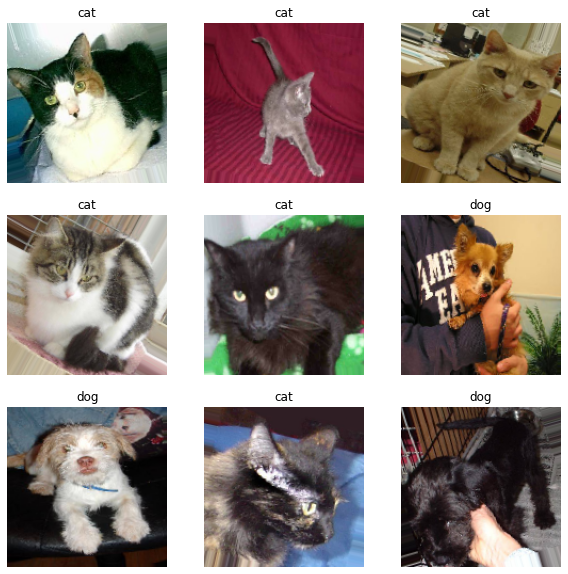

In [ ]:
def create_datagen(df, data_augment = True, name = None):
  if name == 'resnet50':
    p_fun = keras.applications.resnet.preprocess_input
  else:
    p_fun = None

  if data_augment:
    data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255,
                                                            rotation_range=30,
                                                            #width_shift_range=0.1,
                                                            #height_shift_range=0.1,
                                                            #shear_range = 0.2,
                                                            #zoom_range = 0.2,
                                                            #samplewise_center = True,
                                                            horizontal_flip = True,
                                                            preprocessing_function = p_fun)
  else:
    data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255, preprocessing_function = p_fun)

  return data_gen.flow_from_dataframe(df, x_col = 'filename', y_col = 'label',
                                      target_size = image_size, batch_size = batch_size,
                                      class_mode = 'binary', shuffle=False)

# vgg = tf.keras.applications.VGG16(include_top = False, weights='imagenet', input_shape=image_size + (3, ))
# for layer in vgg.layers:
#   layer.trainable = False


# def data_gen_for_feature_extraction(model_name, df, sample_size):
#   generator = create_datagen(model_name, df)
#   x = np.zeros(shape = (sample_size, ) + vgg.output_shape[1:])
#   y = np.zeros(shape = (sample_size))
#   size = 0
#   for images, labels in generator:
#     if size + len(images) > sample_size:
#       break
#     res = vgg.predict(images)
#     x[size : size + len(images)] = res
#     y[size : size + len(images)] = labels
#     size += len(images)
#   if size < x.shape[0]:
#     x = x[:size]
#     y = y[:size]
#   return x, y
    
def show_generator_samples(gen):
  plt.figure(figsize=(10, 10))
  for images, labels in gen:
    print(images.shape, labels.shape)
    for i in range(9):
      plt.subplot(3, 3, i + 1)
      plt.imshow(images[i])
      plt.title(class_names[labels[i].astype('uint8')])
      plt.axis('off')
    break

train_generator = create_datagen(train_df, True)
val_generator = create_datagen(val_df, False)

show_generator_samples(train_generator)

Below are function to build models

In [ ]:
def build_model(model_name, conv_layers = None, dense_layers = None, kernal_size = (3, 3)):
  model = tf.keras.models.Sequential()
  first = True

  i = 1
  for layers in conv_layers:
    j = 1
    for channels in layers:
      layer_name = 'conv2D_block{0}_{1}'.format(i, j)
      if first:
        model.add(keras.layers.Conv2D(channels, kernal_size, name = layer_name, activation = 'relu',
                                      input_shape = image_size + (3, ), padding = 'same'))
        first = False
      else:
        model.add(keras.layers.Conv2D(channels, kernal_size, name = layer_name, activation = 'relu', padding = 'valid'))
      j += 1
    i += 1
      
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'valid'))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.5))
  for units in dense_layers:
    model.add(tf.keras.layers.Dense(units, activation = 'relu'))
    
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

model_mapping = dict([('vgg16', keras.applications.VGG16),
                 ('vgg19', keras.applications.VGG19),
                 ('resnet50', keras.applications.ResNet50), 
                 ('resnet50V2', keras.applications.ResNet50V2)])

def load_pretrained_model(model_name, input_shape, random_weights = False):
  if random_weights:
    return model_mapping[model_name](include_top=False, input_shape = input_shape, weights = None)
  else:
    return model_mapping[model_name](include_top=False, input_shape = input_shape, weights = 'imagenet')  

def set_trainable(base_model, first_trainable_layer_index):
  for layer in base_model.layers:
    layer.trainable = False
  if first_trainable_layer_index > 0:
    for layer in base_model.layers[-first_trainable_layer_index:]:
      layer.trainable = True

def build_fine_tuning_model(base_model, top_layers = [], fine_tune_begin_layer = 0):
  set_trainable(base_model, fine_tune_begin_layer)
  model = keras.models.Sequential()
  model.add(base_model)

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  for units in top_layers:
    model.add(keras.layers.Dense(units, activation = 'relu'))
  
  model.add(keras.layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  
  return model

def build_feature_extract_model(base_model, top_layers = []):
  return build_fine_tuning_model(base_model, top_layers = top_layers, fine_tune_begin_layer = 0)

def create_callbacks(model_name, run_name, save_dir = '.'):
  checkpoint_path = os.path.join(save_dir, run_name + '_{epoch:04d}.ckpt')
  logger_path = os.path.join(save_dir, model_name + '_log.csv')

  return [keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3),
          keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True, save_weights_only=True, monitor = 'val_loss'), 
          keras.callbacks.CSVLogger(logger_path, append = True)]

def plot_hist(hist):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.plot(hist['acc'])
  plt.plot(hist['val_acc'])
  plt.legend(['train', 'validation'])
  plt.title('accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(hist['loss'])
  plt.plot(hist['val_loss'])
  plt.legend(['train', 'validation'])
  plt.title('loss')

## Simple CNN model

Create a CNN model and check the model summary

In [ ]:
model_name = "cnn"
model = build_model(model_name, conv_layers=[[16, 16], [32], [], [64], []], dense_layers = [256])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_block1_1 (Conv2D)     (None, 150, 150, 16)      448       
_________________________________________________________________
conv2D_block1_2 (Conv2D)     (None, 148, 148, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2D_block2_1 (Conv2D)     (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2D_block4_1 (Conv2D)     (None, 16, 16, 64)        1

Epoch 1/20
586/586 [==============================] - 174s 268ms/step - loss: 0.6153 - acc: 0.6498 - val_loss: 0.4815 - val_acc: 0.7590
Epoch 2/20
586/586 [==============================] - 158s 269ms/step - loss: 0.5065 - acc: 0.7517 - val_loss: 0.4464 - val_acc: 0.7869
Epoch 3/20
586/586 [==============================] - 158s 269ms/step - loss: 0.4517 - acc: 0.7884 - val_loss: 0.3881 - val_acc: 0.8214
Epoch 4/20
586/586 [==============================] - 158s 270ms/step - loss: 0.4160 - acc: 0.8067 - val_loss: 0.3691 - val_acc: 0.8358
Epoch 5/20
586/586 [==============================] - 157s 267ms/step - loss: 0.3892 - acc: 0.8209 - val_loss: 0.3158 - val_acc: 0.8579
Epoch 6/20
586/586 [==============================] - 155s 265ms/step - loss: 0.3665 - acc: 0.8346 - val_loss: 0.2998 - val_acc: 0.8701
Epoch 7/20
586/586 [==============================] - 156s 266ms/step - loss: 0.3566 - acc: 0.8412 - val_loss: 0.3813 - val_acc: 0.8222
Epoch 8/20
586/586 [============================

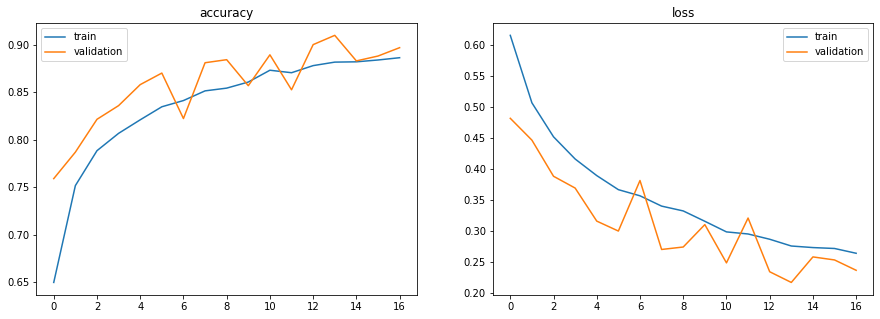

In [ ]:

hist = model.fit(train_generator, epochs=20,
                 validation_data = val_generator,
                 callbacks = create_callbacks('cnn', 'cnn_run3', res_dir))
model.load_weights(tf.train.latest_checkpoint(res_dir))
#model.save('dog_cat_cnn1.h5')
plot_hist(hist.history)

In [ ]:
set_trainable(model, 0)
model2 = keras.models.Sequential();
insertAt = 2
for i in range(len(model.layers)):
  model2.add(model.layers[i])
  if i == insertAt:
    model2.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    break

model2.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'valid'))
model2.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding = 'valid'))
  
model2.add(keras.layers.Flatten())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(256, activation = 'relu'))
model2.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_block1_1 (Conv2D)     (None, 150, 150, 16)      448       
_________________________________________________________________
conv2D_block1_2 (Conv2D)     (None, 148, 148, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)            

Epoch 1/10
586/586 [==============================] - 149s 254ms/step - loss: 0.5410 - acc: 0.7150 - val_loss: 0.4377 - val_acc: 0.7955
Epoch 2/10
586/586 [==============================] - 148s 253ms/step - loss: 0.4598 - acc: 0.7863 - val_loss: 0.4292 - val_acc: 0.7955
Epoch 3/10
586/586 [==============================] - 148s 252ms/step - loss: 0.4369 - acc: 0.7997 - val_loss: 0.3900 - val_acc: 0.8254
Epoch 4/10
586/586 [==============================] - 147s 251ms/step - loss: 0.4240 - acc: 0.8035 - val_loss: 0.3799 - val_acc: 0.8270
Epoch 5/10
586/586 [==============================] - 147s 251ms/step - loss: 0.4069 - acc: 0.8158 - val_loss: 0.3665 - val_acc: 0.8347
Epoch 6/10
586/586 [==============================] - 147s 251ms/step - loss: 0.3966 - acc: 0.8190 - val_loss: 0.3592 - val_acc: 0.8430
Epoch 7/10
586/586 [==============================] - 148s 253ms/step - loss: 0.3885 - acc: 0.8251 - val_loss: 0.3564 - val_acc: 0.8376
Epoch 8/10
586/586 [============================

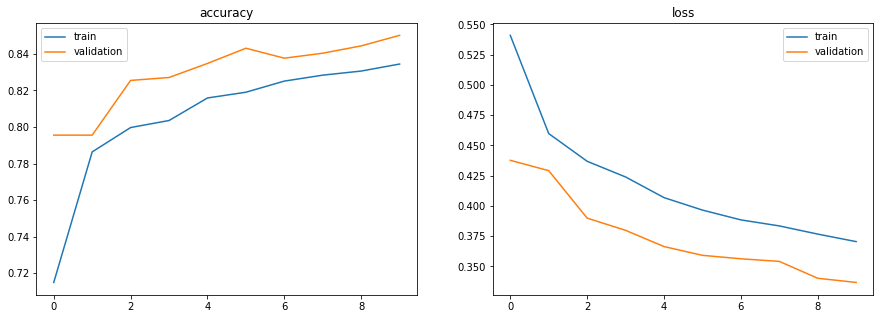

In [ ]:
hist = model2.fit(train_generator, epochs=10,
                 validation_data = val_generator,
                 callbacks = create_callbacks('cnn', 'cnn_run2', res_dir))
model2.load_weights(tf.train.latest_checkpoint(res_dir))
model2.save('dog_cat_cnn2.h5')
plot_hist(hist.history)

## Fine-tuning

In [ ]:
class Fine_tuning_runner:
  def __init__(self, name, model, base_model, fine_tune_layers, save_dir):
    self.name = name
    self.model = model
    self.base_model = base_model
    self.fine_tune_layers = fine_tune_layers
    self.fine_tune_layers.sort()
    self.save_dir = save_dir
  
  def create_callbacks(self, run_name, save_dir = '.'):
    checkpoint_path = os.path.join(save_dir, run_name + '_{epoch:04d}.ckpt')
    logger_path = os.path.join(save_dir, self.name + '_log.csv')
    earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
    checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only = True, save_weights_only=True, monitor = 'val_loss')
    logger = keras.callbacks.CSVLogger(logger_path, append = True)
    return [checkpoint, logger, earlyStop]
  
  def fit(self, train_data, val_data, batch_size, epochs, no_tuning_run = True):
    if not os.path.exists(self.save_dir):
      os.mkdir(self.save_dir)

    if no_tuning_run:
      r = range(len(self.fine_tune_layers) + 1)
    else:
      r = range(1, len(self.fine_tune_layers) + 1)

    for i in r:
      print('{}-th run: '.format(i))
      if i == 0:
        set_trainable(self.base_model, 0)
      else:
        set_trainable(self.base_model, self.fine_tune_layers[i-1])
      print('# of trainable layers = {}'.format(len(self.model.trainable_weights)))

      self.model.fit(train_data, validation_data = val_data,
                     batch_size = batch_size, epochs = epochs,
                     callbacks = self.create_callbacks(self.name + '_run{}'.format(i), save_dir = self.save_dir))
      
      latest = tf.train.latest_checkpoint(self.save_dir)
      print('loading weights from {}'.format(latest))
      self.model.load_weights(latest)


In [ ]:
vgg16 = load_pretrained_model('vgg16', input_shape=image_size + (3,))
model_on_vgg16 = build_feature_extract_model(vgg16, [256])
vgg16.summary()
model_on_vgg16.summary()
print([model_on_vgg16.trainable_weights[i].shape for i in range(len(model_on_vgg16.trainable_weights))])
print(len(model_on_vgg16.trainable_variables))

In [ ]:
runner_vgg16 = Fine_tuning_runner(name = 'vgg16',
                                  model = model_on_vgg16,
                                  base_model = vgg16,
                                  fine_tune_layers = [2, 3, 4], save_dir = res_dir)
runner_vgg16.fit(train_data = train_generator,
                 val_data = val_generator,
                 batch_size = batch_size, epochs = 20)
model_on_vgg16.save(os.path.join(res_dir, 'dog_cat_vgg16.h5'))

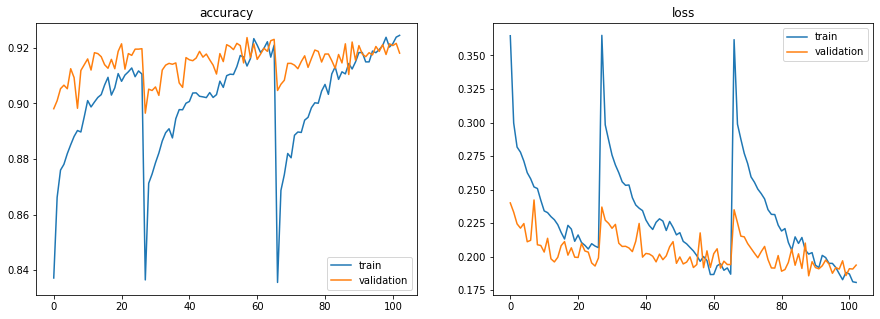

In [ ]:
hist = pd.read_csv(os.path.join(res_dir, 'vgg16_log.csv'))

plot_hist(hist)

In [ ]:
vgg16 = load_pretrained_model('vgg16', input_shape=image_size + (3,))
model_on_vgg16_2 = build_feature_extract_model(vgg16, [256])

runner_vgg16_2 = Fine_tuning_runner(name = 'vgg16_2',
                                  model = model_on_vgg16_2,
                                  base_model = vgg16,
                                  fine_tune_layers = [4], save_dir = res_dir)
runner_vgg16_2.fit(train_data = train_generator,
                 val_data = val_generator,
                 batch_size = batch_size, epochs = 20, no_tuning_run = False)
model_on_vgg16_2.save(os.path.join(res_dir, 'dog_cat_vgg16_2.h5'))

In [ ]:
resnet50V2 = load_pretrained_model('resnet50V2', input_shape=image_size + (3,))
model_on_resnet50V2 = build_feature_extract_model(resnet50V2, [256])
resnet50V2.summary()
model_on_resnet50V2.summary()

In [ ]:
runner_resnet50V2 = Fine_tuning_runner(name = 'resnet50V2',
                                  model = model_on_resnet50V2,
                                  base_model = resnet50V2,
                                  fine_tune_layers = [11], save_dir = res_dir)
runner_resnet50V2.fit(train_data = train_generator,
                 val_data = val_generator,
                 batch_size = batch_size, epochs = 20, no_tuning_run = False)

In [ ]:
model_on_resnet50V2.save(os.path.join(res_dir, 'dog_cat_resnet50V2.h5'))

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
vgg19 = load_pretrained_model('vgg19', input_shape=image_size + (3,))
model_on_vgg19 = build_feature_extract_model(vgg19, [256])
vgg19.summary()
model_on_vgg19.summary()

In [ ]:
runner_vgg19 = Fine_tuning_runner(name = 'vgg19',
                                  model = model_on_vgg19,
                                  base_model = vgg19,
                                  fine_tune_layers = [5], save_dir = res_dir)
runner_vgg19.fit(train_data = train_generator,
                 val_data = val_generator,
                 batch_size = batch_size, epochs = 20, no_tuning_run = False)

model_on_vgg19.save(os.path.join(res_dir, 'dog_cat_vgg19.h5'))

1-th run: 
# of trainable layers = 12
Epoch 1/20
586/586 [==============================] - 139s 236ms/step - loss: 0.4054 - acc: 0.8130 - val_loss: 0.3103 - val_acc: 0.8616
Epoch 2/20
586/586 [==============================] - 135s 230ms/step - loss: 0.3460 - acc: 0.8451 - val_loss: 0.2623 - val_acc: 0.8899
Epoch 3/20
586/586 [==============================] - 137s 233ms/step - loss: 0.3257 - acc: 0.8542 - val_loss: 0.2487 - val_acc: 0.8891
Epoch 4/20
586/586 [==============================] - 137s 234ms/step - loss: 0.3206 - acc: 0.8573 - val_loss: 0.2804 - val_acc: 0.8730
Epoch 5/20
586/586 [==============================] - 135s 231ms/step - loss: 0.3188 - acc: 0.8554 - val_loss: 0.2659 - val_acc: 0.8856
Epoch 6/20
586/586 [==============================] - 139s 237ms/step - loss: 0.3060 - acc: 0.8644 - val_loss: 0.2371 - val_acc: 0.8938
Epoch 7/20
586/586 [==============================] - 137s 233ms/step - loss: 0.3042 - acc: 0.8666 - val_loss: 0.2786 - val_acc: 0.8741
Epoch 8/20

In [ ]:
resnet50 = load_pretrained_model('resnet50', input_shape=image_size + (3,))
model_on_resnet50 = build_feature_extract_model(resnet50, [256])
resnet50.summary()
model_on_resnet50.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

In [ ]:
train_generator = create_datagen(train_df, True, name = 'resnet50')
val_generator = create_datagen(val_df, False, name = 'resnet50')

runner_resnet50 = Fine_tuning_runner(name = 'resnet50',
                                  model = model_on_resnet50,
                                  base_model = resnet50,
                                  fine_tune_layers = [10], save_dir = res_dir)
runner_resnet50.fit(train_data = train_generator,
                 val_data = val_generator,
                 batch_size = batch_size, epochs = 20, no_tuning_run = False)

model_on_resnet50.save(os.path.join(res_dir, 'dog_cat_resnet50.h5'))

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
1-th run: 
# of trainable layers = 16
Epoch 1/20
586/586 [==============================] - 143s 238ms/step - loss: 0.7013 - acc: 0.5771 - val_loss: 0.6512 - val_acc: 0.6206
Epoch 2/20
586/586 [==============================] - 139s 238ms/step - loss: 0.6572 - acc: 0.6097 - val_loss: 0.6570 - val_acc: 0.5709
Epoch 3/20
586/586 [==============================] - 137s 234ms/step - loss: 0.6480 - acc: 0.6226 - val_loss: 0.6101 - val_acc: 0.6742
Epoch 4/20
586/586 [==============================] - 138s 235ms/step - loss: 0.6393 - acc: 0.6348 - val_loss: 0.6008 - val_acc: 0.6864
Epoch 5/20
586/586 [==============================] - 138s 236ms/step - loss: 0.6362 - acc: 0.6350 - val_loss: 0.6032 - val_acc: 0.6933
Epoch 6/20
586/586 [==============================] - 139s 237ms/step - loss: 0.6312 - acc: 0.6423 - val_loss: 0.6757 - val_acc: 0.5643
Epoch 7/20
586/586 [===

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
